# FAISS on Market1501 Dataset (512-dimensions)

Images from a public person re-identification dataset called Market1501 which contains around 32000 low-resolution surveillance images of people. Generic embeddings have been generated using ResNet, which results in 512 dimensional vectors per image. 

In [39]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
from PIL import Image

from os import listdir
from os.path import isfile, join, splitext

Load in the dataset provided.

In [4]:
embeddings_folder = 'data/512d_embedding'
image_folder = 'data/images'

files = [file for file in listdir(embeddings_folder) if isfile(join(embeddings_folder, file))]
print(files[0:10])

['00001480_01_0001.txt', '00001312_01_0001.txt', '00000001_04_0000.txt', '00001403_00_0005.txt', '00001308_02_0003.txt', '00000307_05_0009.txt', '00001219_02_0000.txt', '00000227_05_0035.txt', '00001096_02_0001.txt', '00001386_02_0001.txt']


Load in vectors from .txt files to 2 arrays - one with filename and one without.

From doing some benchmarking tests (for optimization purposes):
- np.append is around the same speed as np.concatenate for 32,000 images. Without np.append, time drops from around 1min 12s to 58s. 
- np.genfromtxt is slightly faster than np.loadtxt (6 seconds faster on average over 32,000 images)

In [5]:
def files_to_array(files, num_dimensions):
    i = 0
    # http://chrisschell.de/2018/02/01/how-to-efficiently-deal-with-huge-Numpy-arrays.html
    arr_with_filename=np.empty((len(files), num_dimensions+1), dtype=np.object) # +1 is the filename at the end
    for f in files:
        vector = np.genfromtxt(join(embeddings_folder, f), delimiter="\r\n")
        filename = [splitext(f)[0]]
        vector_with_filename = np.concatenate((vector,filename), axis=0)
        arr_with_filename[i] = vector_with_filename
        i = i + 1
    return arr_with_filename

In [6]:
%time vectors_and_filename = files_to_array(files, 512)

vectors_and_filename.shape

CPU times: user 1min 4s, sys: 1.75 s, total: 1min 6s
Wall time: 1min 10s


(32217, 513)

In [7]:
# create work array without filename
vectors_only = vectors_and_filename[:,:512]
vectors_only.shape

(32217, 512)

Save the numpy arrays as .npy files to be loaded in more quickly in future.

In [8]:
np.save('data/pg_512d.npy', vectors_only)
np.save('data/pg_512d_with_filename.npy', vectors_and_filename)

In [9]:
# load np
vectors_only = np.load('data/pg_512d.npy')
vectors_and_filename = np.load('data/pg_512d_with_filename.npy')

Construct search space and query vector to run similarity against.

In [21]:
xb = vectors_only.astype('float32')
xq = xb[200:201]  # set query vector. Take a random one from the dataset

print('xb.shape : ',xb.shape)
print('xq.shape: ', xq.shape)

xb.shape :  (32217, 512)
xq.shape:  (1, 512)


Create index and add vectors to index. We use HNSW, which has the highest recall vs search speed performance, but uses more memory (bytes/vector): https://github.com/facebookresearch/faiss/wiki/Faiss-indexes

Measure the time to index as well. Wall time is the actual time it took. Note that CPU time can be more than wall time if it is being processed by multiple CPUs at once.

In [45]:
d = 512 # Number of dimensions

index = faiss.IndexHNSWFlat(d, 25) # https://github.com/nmslib/nmslib/blob/master/python_bindings/parameters.md
# index.hnsw.efConstruction = 40 # Increasing this will increase recall but also indexing time
print('index.is_trained : ', index.is_trained)

%time index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
CPU times: user 56 s, sys: 39.2 ms, total: 56.1 s
Wall time: 28.2 s
index.ntotal :  32217


Save the index to a file which can be quickly re-loaded later on.
See https://github.com/facebookresearch/faiss/wiki/Index-IO,-index-factory,-cloning-and-hyper-parameter-tuning

In [32]:
faiss.write_index(index, "pg_512d_hnsw.index")

Perform search for top k nearest neighbours.

In [46]:
k = 11                         # we want to see 10 nearest neighbors
D, I = index.search(xq, k)     # actual search
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])

I[:5] :  [[  200  4260   423  3652 14986 12568 31045 12149 20677  4400 25674]]
D[:5] :  [[  0.      195.64238 198.66382 200.81802 204.67073 204.6957  207.36346
  209.94998 214.44063 214.4642  214.51605]]


In [47]:
result = np.empty([0,512])
i = 0
for i in range(k):
    print('index : ', I[0,i], '\ndistance : ', D[0,i], '\narr : ', xb[I[0,i]])
    result = np.vstack((result, xb[I[0,i]]))

result.shape

index :  200 
distance :  0.0 
arr :  [4.37541977e-02 1.67885184e+00 2.59796232e-01 4.49258149e-01
 1.14842258e-01 1.91102278e+00 1.26194119e+00 1.76878929e+00
 1.32841611e+00 2.87987024e-01 6.84721649e-01 4.79449064e-01
 4.47912961e-01 5.15974201e-02 1.06095731e+00 6.13351166e-01
 2.01544926e-01 4.66120942e-03 7.71274686e-01 3.26729745e-01
 1.42386660e-01 1.16488242e+00 3.09497535e-01 9.63677347e-01
 4.74733680e-01 1.66463339e+00 2.78207380e-02 2.36162567e+00
 8.30725506e-02 1.43986332e+00 1.49980366e+00 1.45559239e+00
 2.05126166e+00 1.28216004e+00 5.66901267e-01 5.46726525e-01
 9.15704846e-01 7.96717182e-02 3.20966154e-01 9.90229785e-01
 1.69182694e+00 9.35977459e-01 4.11292732e-01 5.78340888e-01
 2.10863280e+00 8.89800429e-01 4.50985521e-01 1.38435420e-03
 3.19588214e-01 1.90826619e+00 1.18569362e+00 4.27697241e-01
 2.07094148e-01 2.95664340e-01 2.04344854e-01 9.44869816e-01
 4.30133641e-01 5.60171485e-01 7.16521800e-01 3.58711243e-01
 1.31037101e-01 2.89710104e-01 7.73026764e-01 8

(11, 512)

View the results visually.

In [35]:
def get_map_image_filename(idx):
    image_filename = vectors_and_filename[idx, -1]
    image_filename = image_filename + '.jpg'
    return image_filename

In [36]:
def draw_vector_map_image(I):
    plt.figure(figsize=(len(I[0])*4,4))
    for index, (array_index) in enumerate(zip(I[0])):
        fname = get_map_image_filename(array_index[0])
        im = Image.open(join(image_folder, fname))
        plt.subplot(1, len(I[0]), index+ 1)
        plt.imshow(im)
        titlestr = 'i:' + str(array_index[0]) + '  filename:', fname
        plt.title(titlestr, fontsize = 10)

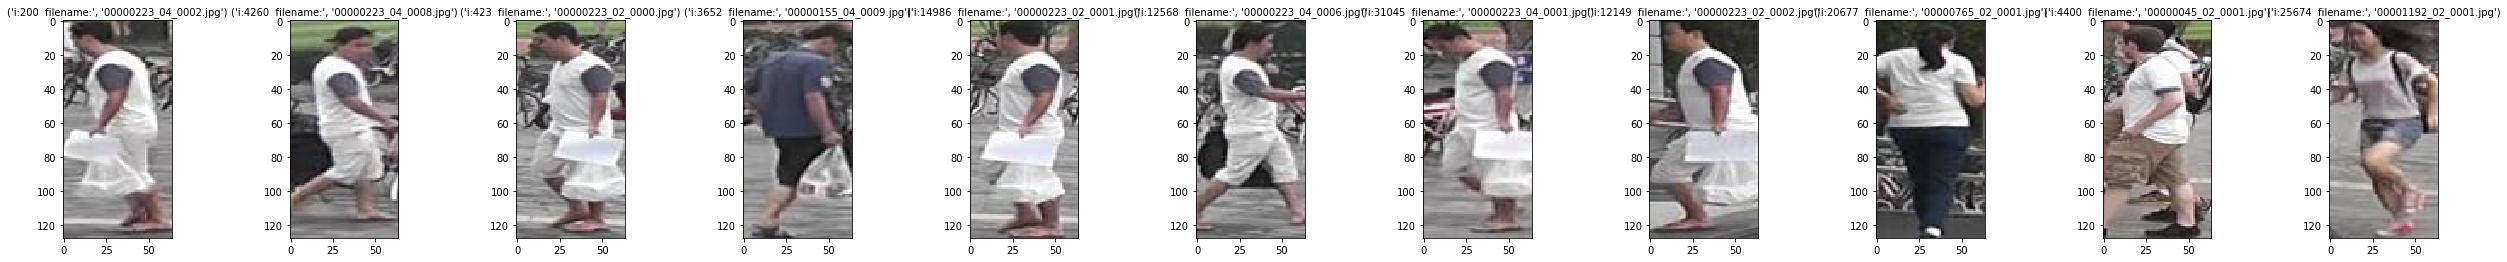

In [48]:
draw_vector_map_image(I) # Where I is the indexes of the top images.

# FAISS on Market1501 Dataset (4096-dimensions)

Images from a public person re-identification dataset called Market1501 which contains around 32000 low-resolution surveillance images of people. Generic embeddings have been generated using AlexNet, which results in 4096 dimensional vectors per image. 

Load in the dataset provided.

In [38]:
embeddings_folder = 'data/4096d_embedding'
image_folder = 'data/images'

files = [file for file in listdir(embeddings_folder) if isfile(join(embeddings_folder, file))]
print(files[0:10])

['00001480_01_0001.txt', '00001312_01_0001.txt', '00000001_04_0000.txt', '00001403_00_0005.txt', '00001308_02_0003.txt', '00000307_05_0009.txt', '00001219_02_0000.txt', '00000227_05_0035.txt', '00001096_02_0001.txt', '00001386_02_0001.txt']


Load in vectors from .txt files to 2 arrays - one with filename and one without.

The operation below takes more than an hour. Txt file format will not be feasible for loading in embeddings. Consider using .h5 format.

In [ ]:
# %%time
# vectors_and_filename_4096 = files_to_array(files, 4096)
# vectors_and_filename_4096.shape